## Crooks fluctuation theorem for work considering a Gaussian Langevin dynamics

In this implementation, we follow the references:
- Fluctuation theorem (FT) for work: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.69.056121,
- Algorithm for simulating stochastic Langevin dynamics: https://aip.scitation.org/doi/abs/10.1063/1.4802990.

In [1]:
import pylab as plt
import numpy as np
import time as tm 
from sys import argv
plt.rcParams.update({'font.size': 12})

### Definitions and functions

In [2]:
# Gaussian estimator
def gaussian_func(x, M, V):
    denominator = np.sqrt(2*np.pi*V)
    numerator = np.exp(-((x-M)**2)/(2*V))
    return numerator/denominator

In [3]:
# Harmonic force and internal energy
def energy_force(x, t, *args):
    v0 = args[0]
    ks = args[1]
    F = -ks*(x - v0*t)
    U = (ks/2)*abs(x-v0*t)**2
    
    return F, U


# Return the time length
def time_len(tMax, dt):

    t = 0
    L = []
    
    while(t<tMax):
        L.append(t)
        t += dt

    return len(L)

### Stochastic evolution BAOAB

for further explanation, read: https://aip.scitation.org/doi/abs/10.1063/1.4802990

In [4]:
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new

def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-np.exp(-2*gamma*dt))*np.sqrt(kBT)
    v_new = c1*v + c2*R
    return v_new


def BAOAB_method(x_init, v_init, v0, tMax, dt, gamma, kBT, ks):
    x = x_init
    v = v_init
    t = 0
    pos = []
    time = []
    dwork = []
    
    _, Ui = energy_force(x, t, v0, ks)
    while(t<tMax):
        
        ##################
        # part B
        F, _ = energy_force(x, t, v0, ks)
        v = velocity_update(v,F,dt)
        
        # part A
        x = position_update(x,v,dt)
        
        # part O
        v = random_velocity_update(v,gamma,kBT,dt)
        
        # part A
        x = position_update(x,v,dt)
    
        # part B
        F, _ = energy_force(x, t, v0, ks)
        v = velocity_update(v,F,dt)
        ##################
        
        # work per trajectory calculation
        F, _ = energy_force(x, t, v0, ks)
        dw = v0*F
        
        pos.append(x)
        time.append(t)
        dwork.append(dw)
        
        t += dt
       
        if t >= tMax//2 :
            v0 = 0

    _, Uf = energy_force(x, t, v0, ks)
    dU = (Uf - Ui)
    return time, dwork, dU   #return: dif internal energy, elapsed time, dif work

### Time evolution for the work variable

In [5]:
###################### MAIN #############################

# Parameters and time
v0 = 0.2
ks = 2.0
gamma = 5.0 
kBT = 1.0
dt = 0.01
tMax = 100  

# Sample conditions
N = 10**4 #int(argv[1])
x_init = 0.3
v_init = 0.

# Work vector definition and extras
w = np.zeros(N)
start = tm.time()

########### Work ###########
# Stochastic time-evolution for each trajectory in a sample
for ii in range(N): 

    time, dwork, dU = BAOAB_method(x_init, v_init, v0, tMax, dt, gamma, kBT, ks)
    # Computing work
    w[ii] = (1/kBT)*np.trapz(dwork, time)
    
# Work statistics
mean_w = np.mean(w)
var_w = np.var(w)

#########################################################

end = tm.time()
print(end-start)

354.0906617641449


### Exporting or getting data

In [6]:
############ Exporting data ################

#output = np.array([w, q])

#data_path = "/home/fariaart/Dropbox/FT_data_%s.txt" %N
#data_path = "/home/des01/mbonanca/fariaart/Resultados/Doutorado/Lutz/FT-80_data_%s.txt" %N
#with open(data_path , "w+") as data:
    #np.savetxt(data, output.T, fmt='%f')
    

############ Getting data ################

#data = np.loadtxt("/home/fariaart/Dropbox/Pesquisa/Doutorado/Lutz/dados/FT/FT_data_100000.txt", float)
#w0 = data[:,0]
#q0 = data[:,1]

#mean_w0 = np.mean(w0)
#var_w0 = np.var(w0)

#mean_q0 = np.mean(q0)
#var_q0 = np.var(q0)

### Plots of 

* $\rho\,(W_{\tau})$
* $\left.\rho\,(W_{\tau})\, \right /\, \rho\,(-W_{\tau})$

<Figure size 640x480 with 0 Axes>

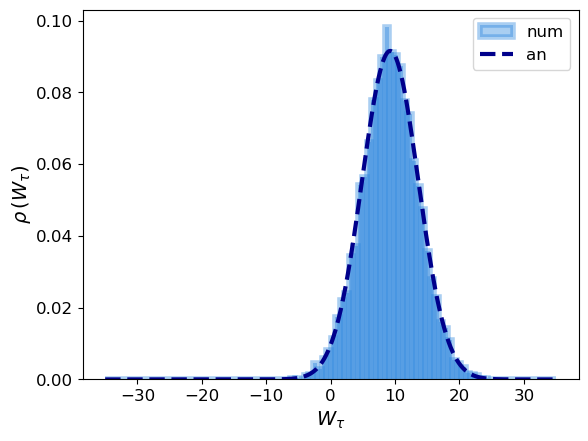

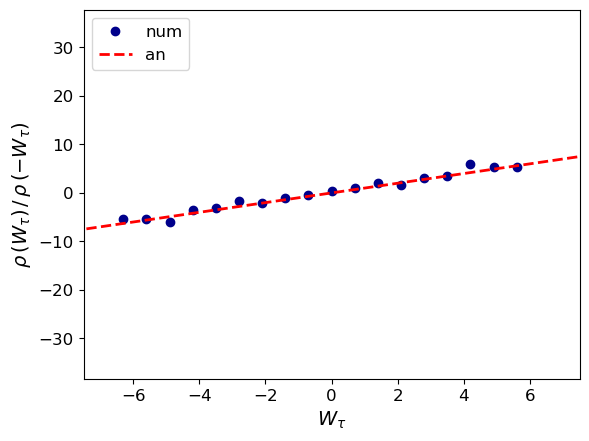

<Figure size 640x480 with 0 Axes>

In [7]:
import warnings
warnings.filterwarnings('ignore')

n_bins = 100 

########## Work Histogram and Analitical curve ##########

n, bins, patches = plt.hist(w, color = (0.165, 0.52, 0.87), range = (-35.,35.), histtype='bar', linewidth=4, alpha= 0.4, ec=(0.165, 0.52, 0.87), bins= n_bins, density=True,  label = 'num')

x = np.linspace(bins[0], bins[n_bins], len(w))
func = gaussian_func(x, mean_w, var_w)
plt.plot(x, func, linestyle = '--', color =  'darkblue', linewidth = 3.0, label = 'an')

# Settings
plt.xlabel(r'$W_{\tau}$', fontsize = 14, labelpad = 4)
plt.ylabel(r'$\rho\,(W_{\tau})$', fontsize = 14, labelpad = 2)
plt.legend(loc='upper right', fontsize = 12)
plt.figure()


########### W Division Histogram ###########

#reversing the freq vector
reverse_n = n[::-1]
n_d = n/reverse_n
div = np.log(n_d)

plt.plot(bins[:-1], div, 'o', color = "darkblue", label = 'num')
plt.plot(bins[:-1],bins[:-1], color = "red",   linestyle = '--', linewidth = 2.0, label = 'an')

# Settings
plt.xlabel(r'$W_{\tau}$', fontsize = 14, labelpad = 4)
plt.ylabel(r'$\rho\,(W_{\tau})\, /\, \rho\,(-W_{\tau})$', fontsize = 14, labelpad = 4)
plt.xlim(-7.5,7.5)

plt.legend(loc='upper left', fontsize = 12)
plt.figure()